# Maximum Likelihood Geodesic Regression

In [1]:
#Modulees

#jax
from jax import jacfwd, vmap
import jax.numpy as jnp
import jax.random as jrandom

#haiku
import haiku as hk

import pandas as pd

#os
import os

#numpy
import numpy as np

import pickle

#matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

#other modules
from load_manifold import get_generator_dim, load_manifold

from gp.gp import RM_EG

#scores
from models import models

#jaxgeometry
from jaxgeometry.statistics.score_matching import model_loader
from jaxgeometry.autodiff import jacfwdx
from jaxgeometry.statistics.score_matching import MLGeodesicRegression, MLGeodesicRegressionEmbedded
from jaxgeometry.statistics.score_matching import ScoreEvaluation
from jaxgeometry.manifolds import *

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
2024-05-21 14:55:51.577873: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Hyper Parameters
T = 0.5
score_path = "scores"
s2_approx = 0
s1loss_type = "dsm"
s2loss_type = "dsm"
s2_type = "s1s2"
seed = 2712

figure_path = '../figures/ml_regression/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [3]:
def get_coords(M, Fx):
    chart = M.centered_chart(Fx)
    return (M.invF((Fx,chart)),chart)

In [4]:
def load_heat_model(manifold, dim):
    M, x0, sampling_method, generator_dim, layers, opt_val = load_manifold(manifold, dim)
    if "Local" in sampling_method:
        method = "Local"
    else:
        method = "Embedded"
    
    s1p_path = ''.join((score_path, f"/{manifold}{dim}/s1p_{s1loss_type}/"))
    layers = get_generator_dim(manifold, generator_dim)[0]

    s1p_model = hk.transform(lambda x: models.MLP_p(dim=generator_dim, layers=layers)(x))
        
    s1p_state = model_loader.load_model(s1p_path)
    
    rng_key = jrandom.PRNGKey(seed)
    
    if method == "Local":
        s1p_fun = lambda x,y,t: s1p_model.apply(s1p_state.params, rng_key, jnp.hstack((x[0],y[0],t)))
    else:
        s1p_fun = lambda x,y,t: s1p_model.apply(s1p_state.params, rng_key, jnp.hstack((M.F(x),M.F(y),t)))
                       
    return M, x0, s1p_fun

In [5]:
def load_score_model(manifold, dim):
    M, x0, sampling_method, generator_dim, layers, opt_val = load_manifold(manifold, dim)
    if "Local" in sampling_method:
        method = "Local"
    else:
        method = "Embedded"
    
    s1_path = ''.join((score_path, f"/{manifold}{dim}/s1_{s1loss_type}/"))
    s2_path = ''.join((score_path, f"/{manifold}{dim}/{s2_type}_{s2loss_type}/"))
    layers = get_generator_dim(manifold, generator_dim)
    layers_s1, layers_s2 = layers

    s1_model = hk.transform(lambda x: models.MLP_s1(dim=generator_dim, layers=layers_s1)(x))
    
    if s2_approx:
        if s2_type == "s2":
            s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers_s2, layers_beta=layers_s2,
                                                            dim=generator_dim, r = max(generator_dim//2,1))(x))
        elif s2_type == "s1s2":
            @hk.transform
            def s2_model(x):

                s1s2 =  models.MLP_s1s2(
                    models.MLP_s1(dim=generator_dim, layers=layers_s1), 
                    models.MLP_s2(layers_alpha=layers_s2, 
                                  layers_beta=layers_s2,
                                  dim=generator_dim,
                                  r = max(generator_dim//2,1))
                    )

                return s1s2(x)[1]
    else:
        s2_model = None
        
    s1_state = model_loader.load_model(s1_path)
    if s2_approx:
        s2_state = model_loader.load_model(s2_path)
    else:
        s2_state = None
    
    rng_key = jrandom.PRNGKey(seed)
    s1_fun = lambda x,y,t: s1_model.apply(s1_state.params, rng_key, jnp.hstack((x,y,t)))
    if s2_approx:
        s2_fun = lambda x,y,t: s2_model.apply(s2_state.params, rng_key, jnp.hstack((x,y,t)))
    else:
        s2_fun = None
        
    ScoreEval = ScoreEvaluation(M,
                                s1_model=s1_fun,
                                s2_model=s2_fun,
                                method = method
                                )
                       
    return M, x0, ScoreEval, s1_fun

## Testing with $\mathbb{R}^{2}$

In [6]:
M, x0, ScoreEval, s1_fun = load_score_model("Euclidean", 2)

using M.Exp for Logarithm


### Generate Test Data

In [7]:
eps = 0.1*np.random.normal(size=(100,2))
X_obs = (vmap(lambda t: jnp.zeros(2)+t*jnp.ones(2))(jnp.linspace(0.1,1,100))+eps, jnp.zeros(100))
X = jnp.linspace(0.1,1,100)
v = jnp.ones(2)*0.5
sigma = 0.5
mu = (jnp.ones(2)*1.0, jnp.zeros(1))

### Testing with True Gradient

In [8]:
mlgr = MLGeodesicRegression(M,
                            lambda x,y,t: M.grady_log_hk(x,y,t)[0],
                            lambda x,y,t: M.gradt_log_hk(x,y,t),
                            Exp = lambda x,v: M.Exp(x,v),
                            gradp_exp = lambda x,v: jacfwdx(lambda x: M.Exp(x,v))(x)[0],
                            gradv_exp = lambda x,v: jacfwd(lambda v: M.Exp(x,v))(v)[0],
                            max_iter=1000,
                            lr_rm=0.01,
                            lr_euc=0.01,
                            min_t = 1e-3,
                            max_t = 1.0,
                            )

In [9]:
mlgr.fit(X_obs, X, v, mu, jnp.array([sigma]).reshape(1), method='Gradient')

Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
E

Epoch 929/1000
Epoch 930/1000
Epoch 931/1000
Epoch 932/1000
Epoch 933/1000
Epoch 934/1000
Epoch 935/1000
Epoch 936/1000
Epoch 937/1000
Epoch 938/1000
Epoch 939/1000
Epoch 940/1000
Epoch 941/1000
Epoch 942/1000
Epoch 943/1000
Epoch 944/1000
Epoch 945/1000
Epoch 946/1000
Epoch 947/1000
Epoch 948/1000
Epoch 949/1000
Epoch 950/1000
Epoch 951/1000
Epoch 952/1000
Epoch 953/1000
Epoch 954/1000
Epoch 955/1000
Epoch 956/1000
Epoch 957/1000
Epoch 958/1000
Epoch 959/1000
Epoch 960/1000
Epoch 961/1000
Epoch 962/1000
Epoch 963/1000
Epoch 964/1000
Epoch 965/1000
Epoch 966/1000
Epoch 967/1000
Epoch 968/1000
Epoch 969/1000
Epoch 970/1000
Epoch 971/1000
Epoch 972/1000
Epoch 973/1000
Epoch 974/1000
Epoch 975/1000
Epoch 976/1000
Epoch 977/1000
Epoch 978/1000
Epoch 979/1000
Epoch 980/1000
Epoch 981/1000
Epoch 982/1000
Epoch 983/1000
Epoch 984/1000
Epoch 985/1000
Epoch 986/1000
Epoch 987/1000
Epoch 988/1000
Epoch 989/1000
Epoch 990/1000
Epoch 991/1000
Epoch 992/1000
Epoch 993/1000
Epoch 994/1000
Epoch 995/

In [10]:
print(f"The estimated values are: \n\t-sigma = {mlgr.sigma}\n\t-v = {mlgr.v}\n\t-mu = {mlgr.p}")

The estimated values are: 
	-sigma = [0.06638466]
	-v = [1.01037539 1.00215531]
	-mu = (Array([ 0.01518674, -0.00847573], dtype=float64), Array([0.], dtype=float64))


Text(0, 0.5, '$x^{2}$')

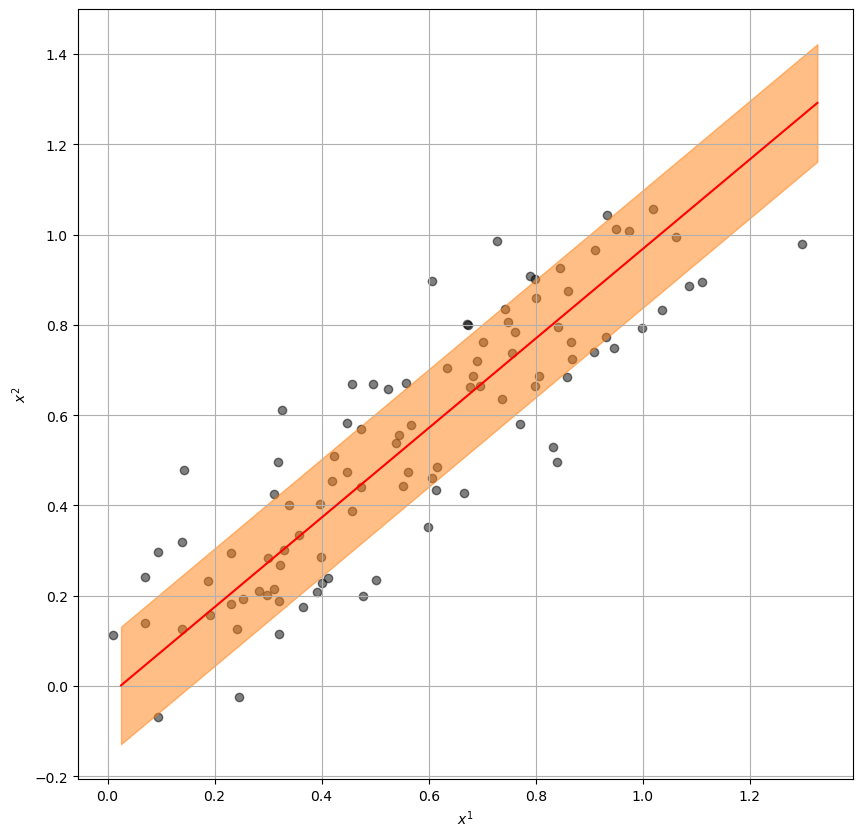

In [11]:
plot1 = mlgr.p[0]+jnp.einsum('i,j->ij',jnp.linspace(jnp.min(X_obs[0][:,0]), jnp.max(X_obs[0][:,0]),100),mlgr.v)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(plot1[:,0], plot1[:,1], color='red')
ax.scatter(X_obs[0][:,0],X_obs[0][:,1], color='black', alpha=0.5)
ax.fill_between(
    plot1[:,0].ravel(),
    plot1[:,1] - 1.96 * mlgr.sigma*jnp.ones_like(plot1[:,1]),
    plot1[:,1] + 1.96 * mlgr.sigma*jnp.ones_like(plot1[:,1]),
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
ax.grid(True)
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')

### Testing with Learned Gradient

In [12]:
mlgr = MLGeodesicRegression(M,
                            ScoreEval.grady_log,
                            ScoreEval.gradt_log,
                            Exp = lambda x,v: M.Exp(x,v),
                            gradp_exp = lambda x,v: jacfwdx(lambda x: M.Exp(x,v))(x)[0],
                            gradv_exp = lambda x,v: jacfwd(lambda v: M.Exp(x,v))(v)[0],
                            max_iter=1000,
                            lr_rm=0.01,
                            lr_euc=0.01,
                            )

In [13]:
mlgr.fit(X_obs, X, v, mu, jnp.array([sigma]).reshape(1), method='Gradient')

Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
E

Epoch 678/1000
Epoch 679/1000
Epoch 680/1000
Epoch 681/1000
Epoch 682/1000
Epoch 683/1000
Epoch 684/1000
Epoch 685/1000
Epoch 686/1000
Epoch 687/1000
Epoch 688/1000
Epoch 689/1000
Epoch 690/1000
Epoch 691/1000
Epoch 692/1000
Epoch 693/1000
Epoch 694/1000
Epoch 695/1000
Epoch 696/1000
Epoch 697/1000
Epoch 698/1000
Epoch 699/1000
Epoch 700/1000
Epoch 701/1000
Epoch 702/1000
Epoch 703/1000
Epoch 704/1000
Epoch 705/1000
Epoch 706/1000
Epoch 707/1000
Epoch 708/1000
Epoch 709/1000
Epoch 710/1000
Epoch 711/1000
Epoch 712/1000
Epoch 713/1000
Epoch 714/1000
Epoch 715/1000
Epoch 716/1000
Epoch 717/1000
Epoch 718/1000
Epoch 719/1000
Epoch 720/1000
Epoch 721/1000
Epoch 722/1000
Epoch 723/1000
Epoch 724/1000
Epoch 725/1000
Epoch 726/1000
Epoch 727/1000
Epoch 728/1000
Epoch 729/1000
Epoch 730/1000
Epoch 731/1000
Epoch 732/1000
Epoch 733/1000
Epoch 734/1000
Epoch 735/1000
Epoch 736/1000
Epoch 737/1000
Epoch 738/1000
Epoch 739/1000
Epoch 740/1000
Epoch 741/1000
Epoch 742/1000
Epoch 743/1000
Epoch 744/

In [14]:
print(f"The estimated values are: \n\t-sigma = {mlgr.sigma}\n\t-v = {mlgr.v}\n\t-mu = {mlgr.p}")

The estimated values are: 
	-sigma = [0.001]
	-v = [1.00304936 1.00824669]
	-mu = (Array([ 0.01743914, -0.003573  ], dtype=float64), Array([0.], dtype=float64))


Text(0, 0.5, '$x^{2}$')

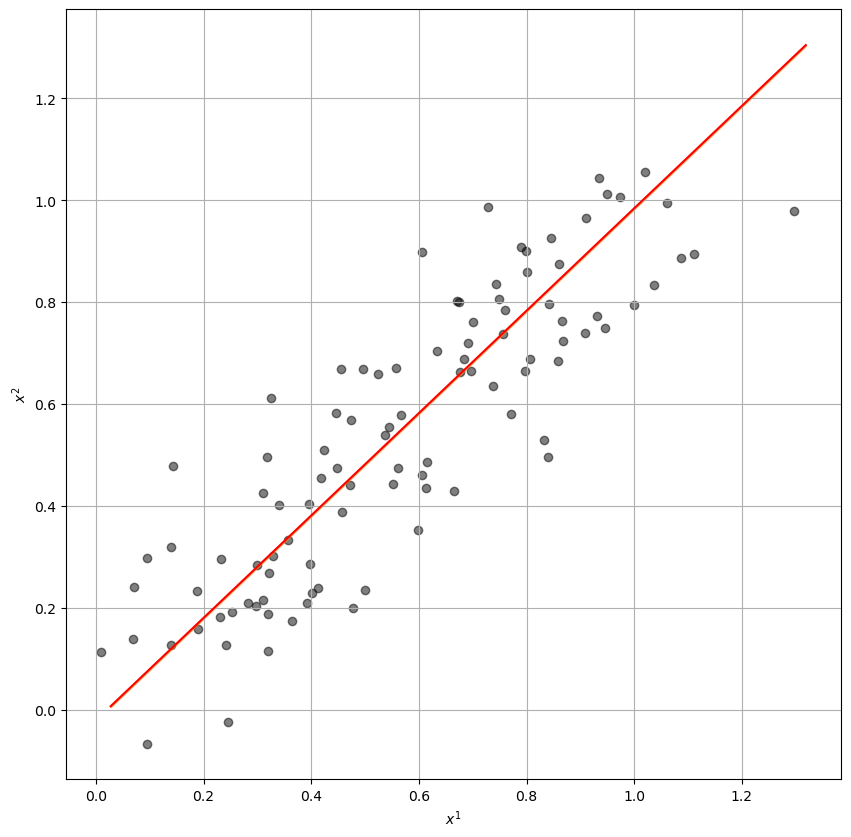

In [15]:
plot1 = mlgr.p[0]+jnp.einsum('i,j->ij',jnp.linspace(jnp.min(X_obs[0][:,0]), jnp.max(X_obs[0][:,0]),100),mlgr.v)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(plot1[:,0], plot1[:,1], color='red')
ax.scatter(X_obs[0][:,0],X_obs[0][:,1], color='black', alpha=0.5)
ax.fill_between(
    plot1[:,0].ravel(),
    plot1[:,1] - 1.96 * mlgr.sigma*jnp.ones_like(plot1[:,1]),
    plot1[:,1] + 1.96 * mlgr.sigma*jnp.ones_like(plot1[:,1]),
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
ax.grid(True)
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')

## Synthetic Data on the $\mathbb{S}^{2}$

In [16]:
M, x0, ScoreEval, s1_fun = load_score_model("Sphere", 2)

using M.Exp for Logarithm


In [17]:
_,_,s1p_fun = load_heat_model("Sphere", 2)

using M.Exp for Logarithm


In [18]:
x0 = jnp.array([0.0,0.0,1.0]) #North pole
v = jnp.array([1.0, 1.0, 0.0]) #Initial direction
X = jnp.linspace(0.1,1,100)
eps = 0.2*np.random.normal(size=(100,3))
data = vmap(lambda t: jnp.cos(jnp.linalg.norm(v)*t)*x0+jnp.sin(jnp.linalg.norm(v)*t)*v/jnp.linalg.norm(v))(X)

data = (data+eps)/jnp.linalg.norm(data+eps, axis=-1).reshape(-1,1)

In [19]:
s2_obs = vmap(lambda x: (M.invF((x,x)), x))(data)

In [20]:
v = jnp.ones(3)*0.5
sigma = 0.5
mu = (s2_obs[0][50], s2_obs[1][50])

In [21]:
def Exp(x,v):
    
    norm_v = jnp.linalg.norm(v)
    
    return jnp.cos(norm_v)*x+jnp.sin(norm_v)*v/norm_v
    
    

In [22]:
def proj(x,v):
    
    return v-jnp.dot(x,v)*x

In [23]:
def grady_log(x,y,t):
        
    if x.ndim == 1:
        return proj(y, s1_fun(x,y,t))
    else:
        return vmap(lambda x1,y1,t1: proj(y1, s1_fun(x1,y1,t1)))(x,y,t)

def gradt_log(x,y,t):

    if x.ndim == 1:
        return ScoreEval.gradt_log(x,y,t)
    else:
        return vmap(lambda x1,y1,t1: ScoreEval.gradt_log(x1,y1,t1))(x,y,t)

In [24]:
grady_log(jnp.array([0.0,0.0,1.0]), jnp.array([0.0,0.0,1.0]), 0.5)

Array([-0.00010497, -0.01771107,  0.        ], dtype=float64)

In [25]:
mlgr = MLGeodesicRegressionEmbedded(M,
                                    grady_log,
                                    gradt_log,
                                    Exp = Exp,
                                    gradp_exp = lambda x,v: jacfwd(lambda x: Exp(x,v))(x),
                                    gradv_exp = lambda x,v: jacfwd(lambda v: Exp(x,v))(v),
                                    proj = proj,
                                    max_iter=1000,
                                    lr_rm=0.1,
                                    lr_euc=0.1,
                                    )

In [26]:
mu[1]

Array([0.58775642, 0.49415711, 0.64058656], dtype=float64)

In [27]:
mlgr.fit(s2_obs[1], X, v, mu[1], jnp.array([sigma]).reshape(1), method='Gradient')

Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
E

Epoch 561/1000
Epoch 562/1000
Epoch 563/1000
Epoch 564/1000
Epoch 565/1000
Epoch 566/1000
Epoch 567/1000
Epoch 568/1000
Epoch 569/1000
Epoch 570/1000
Epoch 571/1000
Epoch 572/1000
Epoch 573/1000
Epoch 574/1000
Epoch 575/1000
Epoch 576/1000
Epoch 577/1000
Epoch 578/1000
Epoch 579/1000
Epoch 580/1000
Epoch 581/1000
Epoch 582/1000
Epoch 583/1000
Epoch 584/1000
Epoch 585/1000
Epoch 586/1000
Epoch 587/1000
Epoch 588/1000
Epoch 589/1000
Epoch 590/1000
Epoch 591/1000
Epoch 592/1000
Epoch 593/1000
Epoch 594/1000
Epoch 595/1000
Epoch 596/1000
Epoch 597/1000
Epoch 598/1000
Epoch 599/1000
Epoch 600/1000
Epoch 601/1000
Epoch 602/1000
Epoch 603/1000
Epoch 604/1000
Epoch 605/1000
Epoch 606/1000
Epoch 607/1000
Epoch 608/1000
Epoch 609/1000
Epoch 610/1000
Epoch 611/1000
Epoch 612/1000
Epoch 613/1000
Epoch 614/1000
Epoch 615/1000
Epoch 616/1000
Epoch 617/1000
Epoch 618/1000
Epoch 619/1000
Epoch 620/1000
Epoch 621/1000
Epoch 622/1000
Epoch 623/1000
Epoch 624/1000
Epoch 625/1000
Epoch 626/1000
Epoch 627/

In [28]:
curve = vmap(lambda x: Exp(mlgr.p/jnp.linalg.norm(mlgr.p), x*proj(mlgr.p,mlgr.v)))(X)

In [29]:
mlgr.sigma

Array([0.27922433], dtype=float64)

In [30]:
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1_S2 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2_S2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3_S2 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))

X_heat = jnp.transpose(jnp.concatenate((X1_S2.reshape(1, ntheta+1, nphi+1), 
                     X2_S2.reshape(1, ntheta+1, nphi+1), 
                     X3_S2.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

numerical_grad = lambda c,y: s1p_fun(get_coords(M,c),get_coords(M,y), mlgr.sigma**2)
score_log_p = vmap(lambda p: vmap(lambda x2: vmap(lambda x1: numerical_grad(p,x1))(x2))(X_heat))(curve)

score_p = jnp.exp(score_log_p)
score_p /= jnp.max(score_p)

In [31]:
score_sum = jnp.sum(score_p, axis=0)

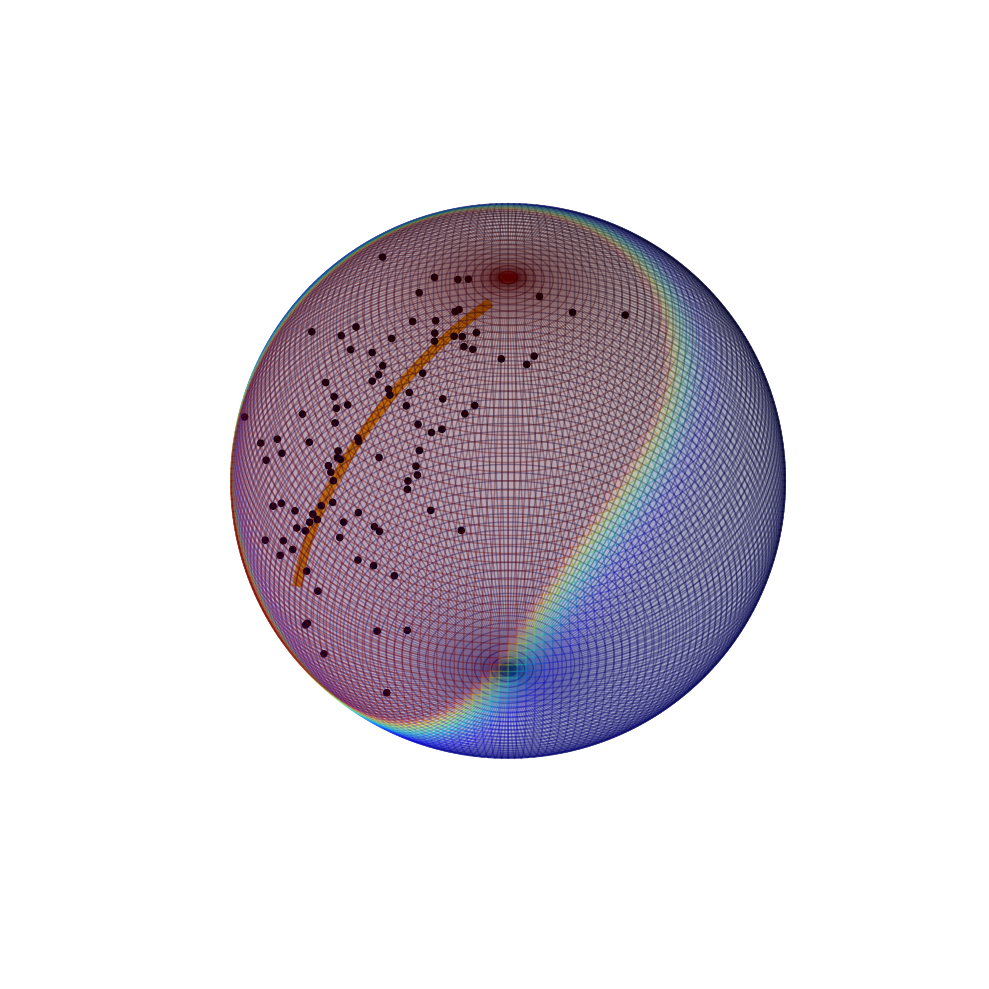

In [32]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
#S2
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2,
               facecolors=plt.cm.jet(score_sum))
ax.scatter(data[:,0], data[:,1], data[:,2], color='black',alpha=1.0)
ax.plot(curve[:,0], curve[:,1], curve[:,2], color='orange', alpha=1.0, linewidth=7.0)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=45., azim=90)

fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

fig.tight_layout()

fig.savefig(f'{figure_path}mlgr_synthetic_sphere.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()